In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import truncnorm

# Generate n values from a truncated normal distribution with mean mu and standard deviation sigma,
# and truncated to the range [min_value, max_value].
def truncated_normal(mu, sigma, min_value, max_value, n):
    if n == 0:
        return np.array([])
    assert min_value < max_value and sigma > 0 and n > 0
    a, b = (min_value - mu) / sigma, (max_value - mu) / sigma
    return np.array([int(x) for x in truncnorm.rvs(a, b, loc=mu, scale=sigma, size=n)])

class Load:
    # For now, sinusoidal time-varying server load model with peak in the afternoon.
    # Load between 0 and 1, in 2-hour intervals starting at 0:00-1:59.
    load_by_hours = [
        0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 0.8, 0.6, 0.6
    ]

    @staticmethod
    def at_hour(hour):
        assert 0 <= hour < 24
        return max(0, min(Load.load_by_hours[hour // 2] + random.uniform(-0.1, 0.1), 1))

class Emissions:
    # Average direct (not including LCA) emissions factors in g CO2e per kWh
    # for electricity consumed for each pair of hours starting
    # with 0:00-1:59, based on hourly data for 2023 from https://electricitymaps.com/.
    gco2_per_kwh_by_hours = {
        'ch': [ 63, 58, 58, 52, 49, 47, 45, 45, 49, 54, 62, 63 ],
    }

    @staticmethod
    def at_hour(hour, country):
        return Emissions.gco2_per_kwh_by_hours[country][hour // 2]

    @staticmethod
    def average(country):
        return sum(Emissions.gco2_per_kwh_by_hours[country]) / len(Emissions.gco2_per_kwh_by_hours[country])


In [2]:
people = {
    'uzh population': {
        'students': 28000,
        'staff': 10000,
    },
}

device_info = {
    'laptops': { 
        'lifetime': 4,
        'count': 38000,
    },
    'desktops': { 
        'lifetime': 6,
        'count': 150,
    },
    'servers': { 
        'lifetime': 5,
        'count': 1028,
    },
    'smartphones': { 
        'lifetime': 3,
        'count': 38000,
    },
    'wall displays': { # Includes projectors
        'lifetime': 6,
        'count': 360,
    },
    'monitors': { 
        'lifetime': 6,
        'count': 10175+150,
    },
    'printers': { 
        'lifetime': 6,
        'count': 1000,
    },
}

embodied_emissions_kg_co2e = {
    'laptops': {
        'average': 244,     # https://github.com/rarecoil/laptop-co2e
        'stdev': 128,       # https://github.com/rarecoil/laptop-co2e
        'lower_bound': 104, # Mean - 1 stdev
        'upper_bound': 372, # Teehan and Kandlikar 2013
    },
    'desktops': {
        'average': 289,     # Dell data
        'stdev': 80,        # Dell data
        'lower_bound': 209, # Mean - 1 stdev
        'upper_bound': 403, # UN Digital Economy report 2024
    },
    'servers': {
        'average': 1252,    # Dell data
        'stdev': 330,       # Dell data
        'lower_bound': 383, # Teehan and Kandlikar 2013
        'upper_bound': 1582,# Mean + 1 stdev
    },
    'smartphones': {
        'average': 50,      # UN Digital Economy report 2024
        'stdev': 10,
        'lower_bound': 30,
        'upper_bound': 70,  # Pixel 8
    },
    'monitors': {
        'average': 344,     # Teehan and Kandlikar 2013
        'stdev': 50,        # Guess
        'lower_bound': 294, # Mean - 1 stdev
        'upper_bound': 394, # Mean + 1 stdev
    },
    'wall displays': {
        'average': 753,     # Scaled from monitors
        'stdev': 109,       # Scaled from monitors
        'lower_bound': 644, # Mean - 1 stdev
        'upper_bound': 862 ,# Mean + 1 stdev
    },
    'printers': {
        'average': 1167,    # Ecoinvent
        'stdev': 200,       # Guess
        'lower_bound': 967, # Mean - 1 stdev
        'upper_bound': 1367,# Mean + 1 stdev
    },
}

power_w = {
    # Assumptions based on some manufacturer data sheets.
    'laptops': {
        'average': 30,
        'stdev': 5,
        'lower_bound': 20,
        'upper_bound': 40,
        'standby': 1,
    },
    'desktops': {
        'average': 100,      
        'stdev': 20,         
        'lower_bound': 60,
        'upper_bound': 200,
        'standby': 1,
    },
    'servers': {
        'average': 400,
        'stdev': 100,
        'lower_bound': 200,
        'upper_bound': 600,
        'standby': 1,
    },
    'smartphones': {
        'average': 5,
        'stdev': 2,
        'lower_bound': 3,
        'upper_bound': 7,
        'standby': 0,
    },
    'monitors': {
        'average': 50,
        'stdev': 10,
        'lower_bound': 30,
        'upper_bound': 90,
        'standby': 1,
    },
    'wall displays': {
        'average': 250,
        'stdev': 50,
        'lower_bound': 150,
        'upper_bound': 350,
        'standby': 1,
    },
    'printers': {
        'average': 1000,
        'stdev': 200,
        'lower_bound': 600,
        'upper_bound': 1400,
        'standby': 90,
    },
}

duty_cycle_6h = {
    # Fraction of time active during 0:00-5:59, 6:00-11:59, 12:00-17:59, 18:00-23:59.
    'laptops': [0.1, 0.5, 1.0, 0.3],
    'desktops': [0.1, 0.5, 1.0, 0.3],
    'servers': [0.8, 0.8, 0.8, 0.8],
    'smartphones': [0.0, 0.0, 0.0, 0.5], # Evening recharge
    'monitors': [0.1, 0.5, 1.0, 0.3],
    'wall displays': [0.0, 0.3, 0.6, 0.1],
    'printers': [0.0, 0.0, 0.01, 0.0], # Five minutes per day of active printing
}

cloud_server_data = {
    'cloud_server': {
        'percent servers in cloud': 0,
        'cloud servers / local server': 1,
        'annual manufacturing kg CO2e': 97,
        'annual usage kg CO2e': 31,
    }
}

llm_usage = {
    'LLM daily user queries': {
        'average': 15,
        'stdev': 5,
        'lower_bound': 0,
        'upper_bound': 30,
    },
}

llm_power = {
    'LLM power': {
        'average query Wh': 3.5,
        'emissions intensity g CO2e / kWh': 226, # (EU average) https://www.climate-transparency.org/wp-content/uploads/2022/10/CT2022-EU-Web.pdf
    },
}

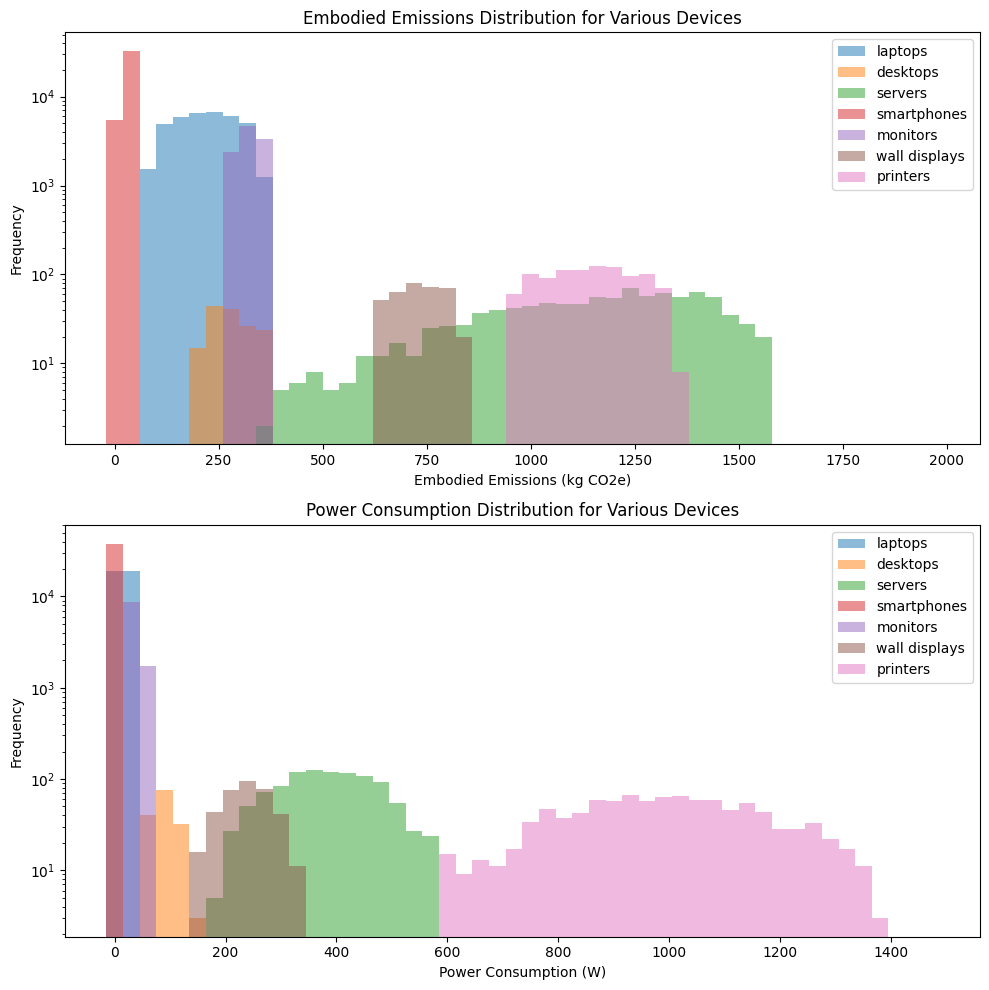

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Precompute and use bar plots for faster rendering
for device, stats in embodied_emissions_kg_co2e.items():
    n = device_info[device]['count']
    samples = truncated_normal(stats['average'], stats['stdev'], stats['lower_bound'], stats['upper_bound'], n)
    counts, bins = np.histogram(samples, bins=50, range=(0, 2000))
    ax1.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, label=device)

ax1.set_xlabel('Embodied Emissions (kg CO2e)')
ax1.set_ylabel('Frequency')
ax1.set_title('Embodied Emissions Distribution for Various Devices')
ax1.set_yscale('log')
ax1.legend()

for device, stats in power_w.items():
    n = device_info[device]['count']
    samples = truncated_normal(stats['average'], stats['stdev'], stats['lower_bound'], stats['upper_bound'], n)
    counts, bins = np.histogram(samples, bins=50, range=(0, 1500))
    ax2.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, label=device)

ax2.set_xlabel('Power Consumption (W)')
ax2.set_ylabel('Frequency')
ax2.set_title('Power Consumption Distribution for Various Devices')
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
from ipywidgets import Button, HBox, HTML, Label, Output, VBox
from input_table import create_inputs
import numpy as np
import pandas as pd

# For each 2h interval, for each device type, emissions intensity in gCO2e per kWh, scaled by duty cycle.
emissions_intensity = {}

# For each device type, instance attributes (power, embodied emissions, etc.) picked from an appropriate distribution.
devices = {}

# Number of data center servers moved to the cloud.
cloud_instances = 0

# Number of LLM queries by user.
llm_queries = None

def generate_devices():
    global devices, emissions_intensity, cloud_instances, llm_queries
    devices = {device: {} for device in device_info.keys()}
    for device, stats in embodied_emissions_kg_co2e.items():
        n = device_info[device]['count']
        if device == 'servers':
            cloud_instances = cloud_server_data['cloud_server']['percent servers in cloud'] * n // 100
            n -= cloud_instances
        devices[device]['annual_embodied_emissions'] = truncated_normal(stats['average'], stats['stdev'], stats['lower_bound'], stats['upper_bound'], n) / device_info[device]['lifetime']
        devices[device]['power_w'] = truncated_normal(power_w[device]['average'], power_w[device]['stdev'], power_w[device]['lower_bound'], power_w[device]['upper_bound'], n)
        devices[device]['standby_w'] = np.array(power_w[device]['standby'] * n)
        # Compute product of emissions intensity and duty cycle in 2-hour intervals.
        r = 24 // len(duty_cycle_6h[device])
        emissions_intensity[device] = np.array([duty_cycle_6h[device][i // r] * Emissions.at_hour(i, 'ch') for i in range(24)])
    q = llm_usage['LLM daily user queries']
    p = people['uzh population']['students'] + people['uzh population']['staff']
    llm_queries = truncated_normal(q['average'], q['stdev'], q['lower_bound'], q['upper_bound'], p)

def annual_usage_emissions_kgco2e(device):
    # Emission intensity (weighted by duty cycle) is in gCO2e per kWh for each hour of the day.
    # (If emission intensity at 10:00-11:00 is 80 gCO2e/kWh, and device is on for 30 minutes, then 40 gCO2e/kWh.)
    # Device power is in W. Divide power by 1000 to convert to kW.
    # Multiply sum of duty-cycle-weighted emission intensity by power to get gCO2e for a day.
    # Multiply result by 365 to get gCO2e per year.
    # Divide by 1000 to get kgCO2e per year.
    return np.sum(devices[device]['power_w'] * np.sum(emissions_intensity[device])) * 365 / 1000 / 1000

def annual_embodied_emissions_kgco2e(device):
    return np.sum(devices[device]['annual_embodied_emissions'])

def cloud_usage_emissions_kgco2e():
    return (cloud_instances * cloud_server_data['cloud_server']['cloud servers / local server'] *
            cloud_server_data['cloud_server']['annual usage kg CO2e'])

def cloud_manufacturing_emissions_kgco2e():
    return (cloud_instances * cloud_server_data['cloud_server']['cloud servers / local server'] *
            cloud_server_data['cloud_server']['annual manufacturing kg CO2e'])

def llm_usage_emissions_kgco2e():
    e = llm_power['LLM power']['average query Wh']
    i = llm_power['LLM power']['emissions intensity g CO2e / kWh']
    # Divide by 1000 to convert Wh to kWh, and by 1000 to convert g to kg.
    return np.sum(llm_queries) * 365 * e * i / 1000 / 1000

def update_devices(_):
    generate_devices()
    refresh_output()

def refresh_output():
    t = 0
    data = []
    for device in device_info.keys():
        u = annual_usage_emissions_kgco2e(device)
        e = annual_embodied_emissions_kgco2e(device)
        t += e + u
        data.append({'Category': device, 'Embodied (kg CO2e)': e, 'Usage (kg CO2e)': u})

    u = cloud_usage_emissions_kgco2e()
    m = cloud_manufacturing_emissions_kgco2e()
    t += u + m
    data.append({'Category': 'Cloud', 'Embodied (kg CO2e)': m, 'Usage (kg CO2e)': u})

    u = llm_usage_emissions_kgco2e()
    t += u
    data.append({'Category': 'LLM', 'Embodied (kg CO2e)': None, 'Usage (kg CO2e)': u})

    data.append({'Category': 'Total', 'Embodied (kg CO2e)': None, 'Usage (kg CO2e)': t})

    # Create a DataFrame
    df = pd.DataFrame(data)

    df_display = df.copy()
    df_display[['Embodied (kg CO2e)', 'Usage (kg CO2e)']] = df_display[['Embodied (kg CO2e)', 'Usage (kg CO2e)']].map(
        lambda x: f"{int(round(x))}" if pd.notnull(x) else ""
    )
    output_table.value = df_display.to_html(index=False, escape=False)
    output_chart.clear_output()
    with output_chart:
        ax = df.iloc[:-1].set_index('Category')[['Embodied (kg CO2e)', 'Usage (kg CO2e)']].plot(
            kind='bar', figsize=(10, 6), stacked=True
        )
        ax.set_ylabel('kg CO2e')
        ax.set_title('CO2e Emissions Breakdown')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
label_device_info = Label(value='Devices')
inputs_device_info = create_inputs(device_info, update_devices)
box_device_info = VBox([label_device_info, inputs_device_info])

label_embodied = Label(value='Embodied Emissions kg CO2e')
inputs_embodied = create_inputs(embodied_emissions_kg_co2e, update_devices)
box_embodied = VBox([label_embodied, inputs_embodied])

label_power = Label(value='Power Consumption W')
inputs_power = create_inputs(power_w, update_devices)
box_power = VBox([label_power, inputs_power])

label_cloud = Label(value='Cloud parameters')
inputs_cloud = create_inputs(cloud_server_data, update_devices, sliders=False)
box_cloud = VBox([label_cloud, inputs_cloud])

label_llm_usage = Label(value='LLM usage')
inputs_llm_usage = create_inputs(llm_usage, update_devices, sliders=False)
box_llm_usage = VBox([label_llm_usage, inputs_llm_usage])

label_llm_power = Label(value='LLM power')
inputs_llm_power = create_inputs(llm_power, update_devices)
box_llm_power = VBox([label_llm_power, inputs_llm_power])

label_recompute = Label(value='Click to perform a new run')
button_recompute = Button(description="Refresh", button_style='success')
button_recompute.on_click(update_devices)
box_recompute = HBox([label_recompute, button_recompute])

output_table = HTML()
output_chart = Output()

update_devices(None)
display(box_embodied, box_power,
        box_device_info, box_cloud,
        box_llm_usage, box_llm_power,
        box_recompute,
        output_table, output_chart,
        clear=True)


Button(button_style='success', description='Refresh', style=ButtonStyle())

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Ca…

Output()